# Create Project

In [77]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

## Functions

In [78]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [79]:
# get coefficients function
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [80]:
# plot coefficients functions
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    fig= ax.get_figure()
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
#sns.plt.show()
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

In [81]:
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

##  Load the Data

In [82]:
#create pandas dataframe
filename='Data/sales_predictions - sales_predictions (1).csv'
df = pd.read_csv(filename)

In [9]:
## Display the first (5) rows of the dataframe
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
## Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent \
{df.shape[1]-1} features and 1 target variable.')


There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


In [11]:
# Fix the fat content row done in all projects
# fix the inconsistencies  in the "item_Fat_Content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [49]:
# there is missing data in "Item_weight" and will drop these rows
#df.dropna(inplace = True)

## Explore the data

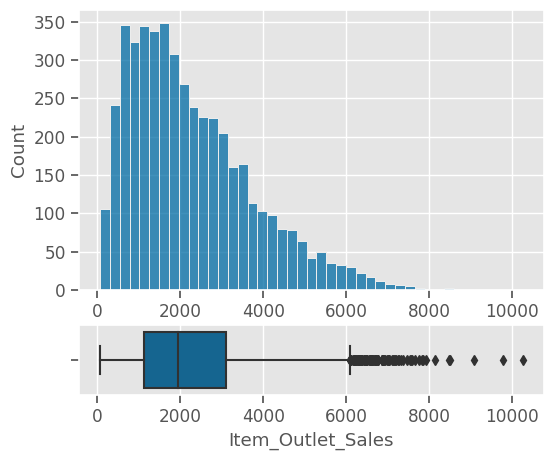

In [50]:
#create EDA of the target
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

## Preprocessing

In [83]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")


Python 3.9.15
sklearn version: 1.1.3


In [52]:
#Set target
target = 'Item_Outlet_Sales'
X = df.drop(columns = target)
y = df[target]

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
3527,FDQ36,7.8550,Regular,0.0000,Baking Goods,38.3848,OUT046,1997,Small,Tier 1,Supermarket Type1
7331,FDT31,19.7500,Low Fat,0.0125,Fruits and Vegetables,188.0872,OUT018,2009,Medium,Tier 3,Supermarket Type2
4003,DRO47,10.1950,Low Fat,0.0000,Hard Drinks,114.0860,OUT046,1997,Small,Tier 1,Supermarket Type1
2737,FDA33,6.4800,Low Fat,0.0339,Snack Foods,146.9076,OUT046,1997,Small,Tier 1,Supermarket Type1
3553,FDW47,15.0000,Low Fat,0.0464,Breads,122.8414,OUT046,1997,Small,Tier 1,Supermarket Type1


In [53]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [54]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
647,5.6550,0.1754,147.4102,"1,999.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
5643,18.8500,0.1416,169.0132,"2,004.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000
3640,13.5000,0.0000,84.5540,"2,009.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000


# Models

## Baseline linear regression

In [55]:
# first lin reg
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.70,579.46,824.30
Test,"-149,221,048,598,431,520.00","147,541,605,114.47","572,044,856,540.76"


In [56]:
#visualize coefficients (manually)
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

Item_Weight                  -406,962,752,953.7597
Item_Visibility                            48.9187
Item_MRP                                    5.1758
Outlet_Establishment_Year   2,599,629,907,887.6641
Item_Identifier_DRA12        -448,996,799,935.2266
Name: Coefficients, dtype: float64

In [57]:
#look at goefficients
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                             -406,962,752,953.7597
Item_Visibility                                       48.9187
Item_MRP                                               5.1758
Outlet_Establishment_Year              2,599,629,907,887.6641
Item_Identifier_DRA12                   -448,996,799,935.2266
Item_Identifier_DRA24                  3,647,519,809,880.8281
Item_Identifier_DRA59                   -861,627,493,915.2148
Item_Identifier_DRB01                 -2,162,309,990,022.3301
Item_Identifier_DRB13                 -1,738,632,226,912.7148
Item_Identifier_DRB24                 -1,594,596,949,351.0278
Item_Identifier_DRB25                   -164,122,872,934.8497
Item_Identifier_DRB48                  2,589,416,649,664.3042
Item_Identifier_DRC01                 -1,817,989,964,893.1890
Item_Identifier_DRC12                  2,094,520,405,803.4512
Item_Identifier_DRC13                   -865,697,121,949.3352
Item_Identifier_DRC24                  2,094,520,407,340.7937
Item_Ide

In [58]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

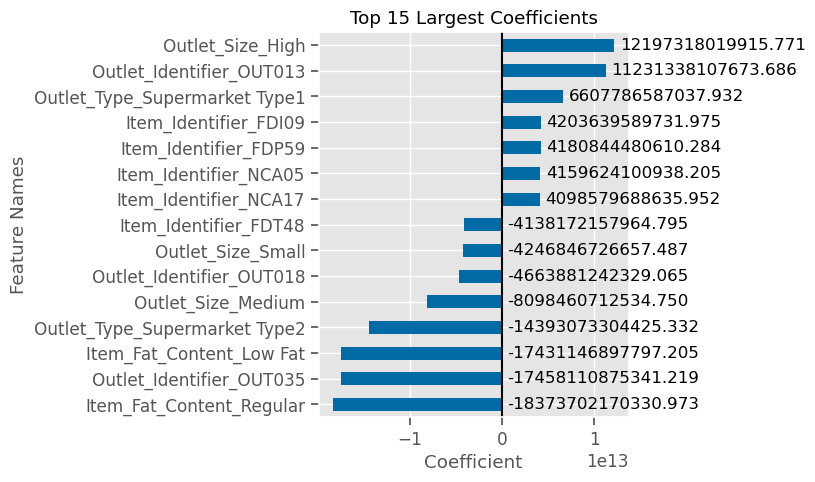

In [59]:
#plot coeffs with function
lr_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
#fig.savefig('Images/Top 15 with Linear Regression')


### Three most impactful coefficients:¶


- Outlet size: the size of the outlet affect grocery sales
- Outlet identifier- this is a not useful index
- Outlet type: similar to size but differences between a grocery store and an outlet

### address coefficients with multicollinearity

## Drop Coefficients without Outlet Identifier

In [60]:
## Get a list of all of the outlet identifier columns
outid_feats = [c for c in X_train_df.columns if c.startswith('Outlet_Identifier')]
len(outid_feats)

5

In [61]:
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = ["Outlet_Identifier", "Item_Identifier"]

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [62]:
# run prerpocessor
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)

In [63]:
#evaluate without  outlet identifier
lin_reg2= LinearRegression(fit_intercept=False)
lin_reg2.fit(X_train_df,y_train)
evaluate_regression(lin_reg2, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.47,810.33,"1,091.18"
Test,0.47,785.24,"1,080.82"


In [64]:
#visualize coefficients (manually)
coeffs2 = pd.Series(lin_reg2.coef_, index=feature_names,
                        name='Coefficients')
coeffs2.loc['intercept'] = lin_reg.intercept_
coeffs2.head()

Item_Weight                   -4.0406
Item_Visibility             -717.3140
Item_MRP                      16.3610
Outlet_Establishment_Year      0.0155
Item_Fat_Content_Low Fat     -11.3829
Name: Coefficients, dtype: float64

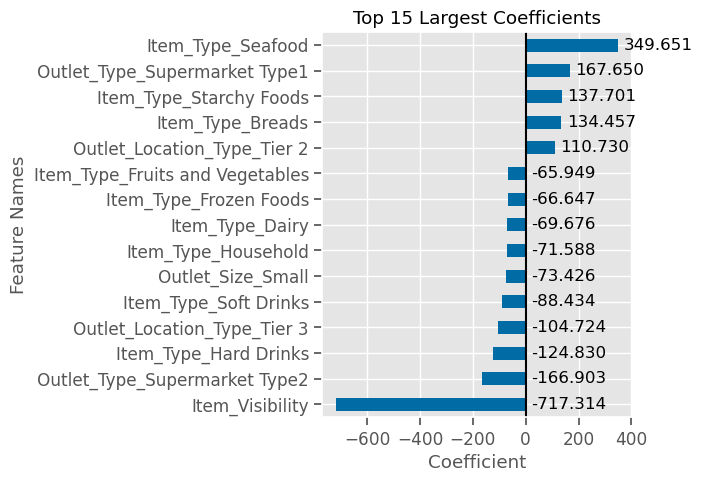

In [65]:
lr_plot = plot_coeffs(coeffs2,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
#fig.savefig('Images/Top 15 with Linear Regression2')

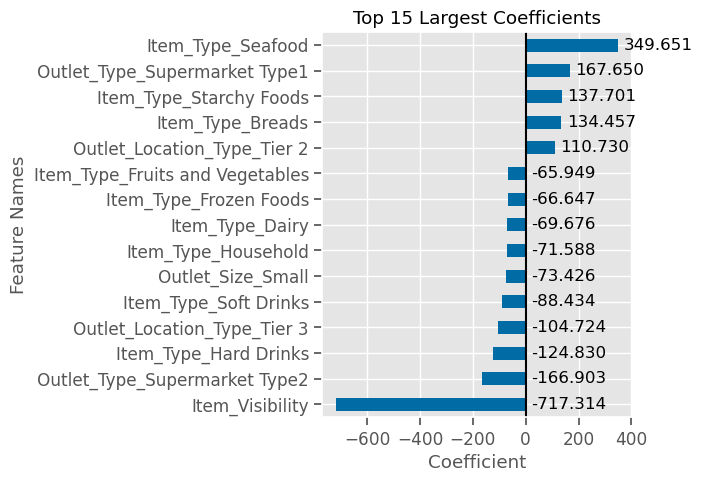

In [66]:
lr_plot = plot_coeffs(coeffs2,top_n=15,intercept=False,annotate=True);
fig=lr_plot.get_figure()
#fig.savefig('Images/Top 15 with Linear Regression_no Outlet Indentifier')

### Five most important features in linear regression without outlet identifier type
- Item Type Low Fat: Fat content affect sales
- Item Type Regular Fat: Fat content affect sales
- Outlet Location 3:  where the supermarket is affects sales
- Outlet Location 2:  where the supermarket is affects sales
- Outlet Location 1:  where the supermarket is affects sales

## Random Forest Model

In [67]:
# instantiate the model, fit and evaluate
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.92,317.62,436.52
Test,0.38,844.42,"1,163.80"


In [68]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                       0.0986
Item_Visibility                   0.1242
Item_MRP                          0.5976
Outlet_Establishment_Year         0.0215
Item_Fat_Content_Low Fat          0.0065
Item_Fat_Content_Regular          0.0069
Item_Type_Baking Goods            0.0072
Item_Type_Breads                  0.0045
Item_Type_Breakfast               0.0033
Item_Type_Canned                  0.0068
Item_Type_Dairy                   0.0068
Item_Type_Frozen Foods            0.0073
Item_Type_Fruits and Vegetables   0.0100
Item_Type_Hard Drinks             0.0029
Item_Type_Health and Hygiene      0.0057
Item_Type_Household               0.0083
Item_Type_Meat                    0.0053
Item_Type_Others                  0.0018
Item_Type_Seafood                 0.0018
Item_Type_Snack Foods             0.0129
Item_Type_Soft Drinks             0.0052
Item_Type_Starchy Foods           0.0035
Outlet_Size_High                  0.0039
Outlet_Size_Medium                0.0074
Outlet_Size_Smal

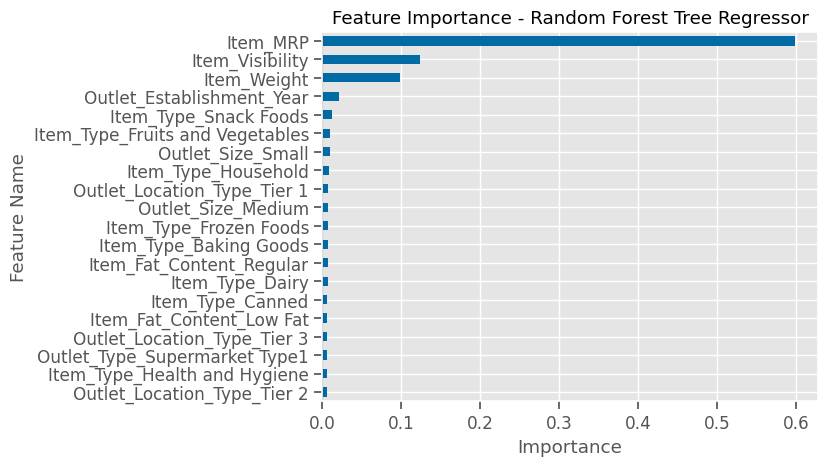

In [69]:
# Create plot
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Random Forest Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');
fig.savefig('Images/Feature Importance with Random Forest')

### Five most important features for random forest
- 1. Item MRP: suggest retail prices affects the sale
- 2. Outlet Type Grocery  affects the sales
- 3. Item visibility affects the sales
- 4. Item weight affects the sales
- 5. Outlet Type Supermarket affects  the sales

### Adding the sixth
- 6. Outlet Year affects the sales: this was significant in earlier projects


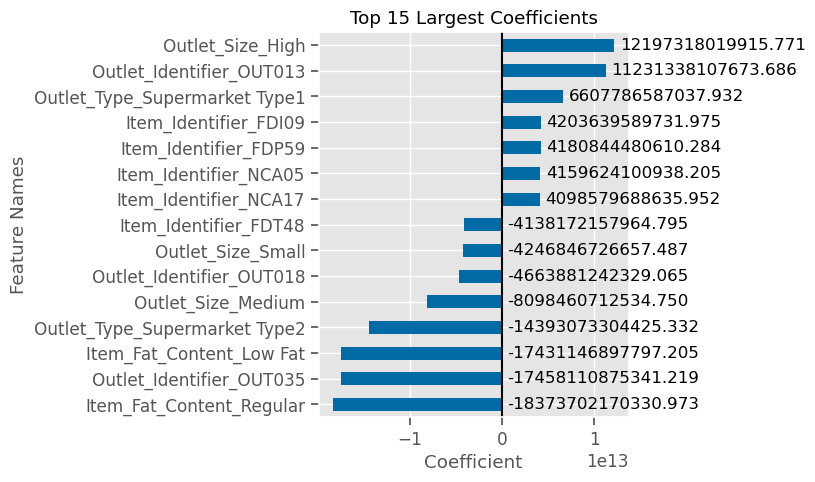

In [70]:
#save image
rf_plot = plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig=rf_plot.get_figure()
fig.savefig('Images/Top 15 with Random Forest')

# Export Data Using Joblib

In [57]:
# evaluate linear regression
evaluate_regression(lin_reg2,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.79,"1,114.98"
Test,0.56,859.97,"1,164.41"


In [58]:
#evaluate random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,294.49,426.73
Test,0.56,819.10,"1,167.93"


In [73]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [74]:
#create folder
folder = "Models/"
os.makedirs(folder, exist_ok=True)

In [75]:
fname = folder+'grocery_sales2'
joblib.dump(export, fname)

['Models/grocery_sales2']

In [76]:
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])